In [ ]:
import pandas as pd
import urllib.parse

sheet_id = '1DWj6qFX6o_Swm2jo2ID1to0gAuQ48EhNSM6URPlgiqc'
sheet_names = ['0527', '0522', 'Avg']

all_dfs = []

for sheet in sheet_names:
    encoded_sheet = urllib.parse.quote(sheet)  # ✅ 進行 URL 編碼
    url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={encoded_sheet}'
    df = pd.read_csv(url)
    df['SourceSheet'] = sheet
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

print(combined_df.columns.tolist())
print(combined_df.head())


['日期', '5/27', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'SourceSheet', '5/22', '日期 時間 ', '兩天平均 早上(8:55 - 9 :15) 搭電梯人數', '走樓梯人數', '中午(11:55 - 12 :15) 搭電梯人數', '走樓梯人數.1', '下午(15:55 - 16 :15) 搭電梯人數', '走樓梯人數.2']
     日期  5/27  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  \
0    時間   NaN         NaN         NaN         NaN         NaN         NaN   
1  第一分鐘   5.0         1.0         5.0         2.0         2.0         1.0   
2  第二分鐘   6.0         1.0         4.0         1.0         2.0         0.0   
3  第三分鐘   7.0         1.0         7.0         0.0         3.0         1.0   
4  第四分鐘   6.0         1.0         2.0         0.0         4.0         1.0   

   Unnamed: 7 SourceSheet  5/22 日期 時間   兩天平均 早上(8:55 - 9 :15) 搭電梯人數  走樓梯人數  \
0         NaN        0527   NaN    NaN                          NaN    NaN   
1         NaN        0527   NaN    NaN                          NaN    NaN   
2         NaN        0527   NaN    NaN               

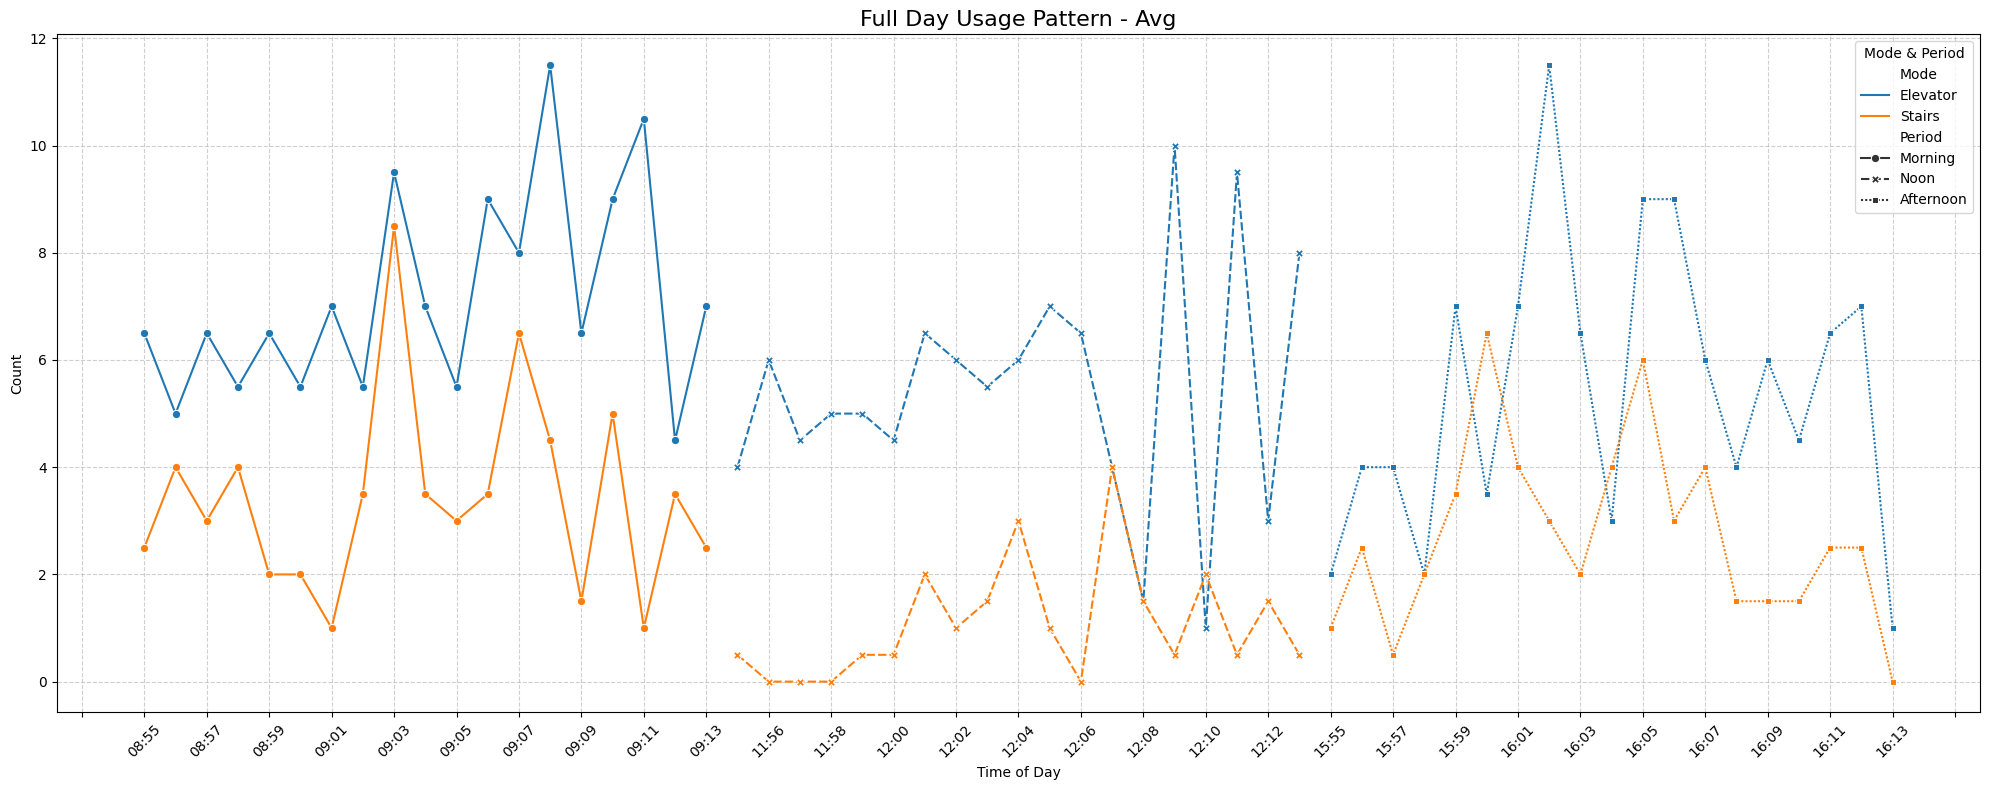

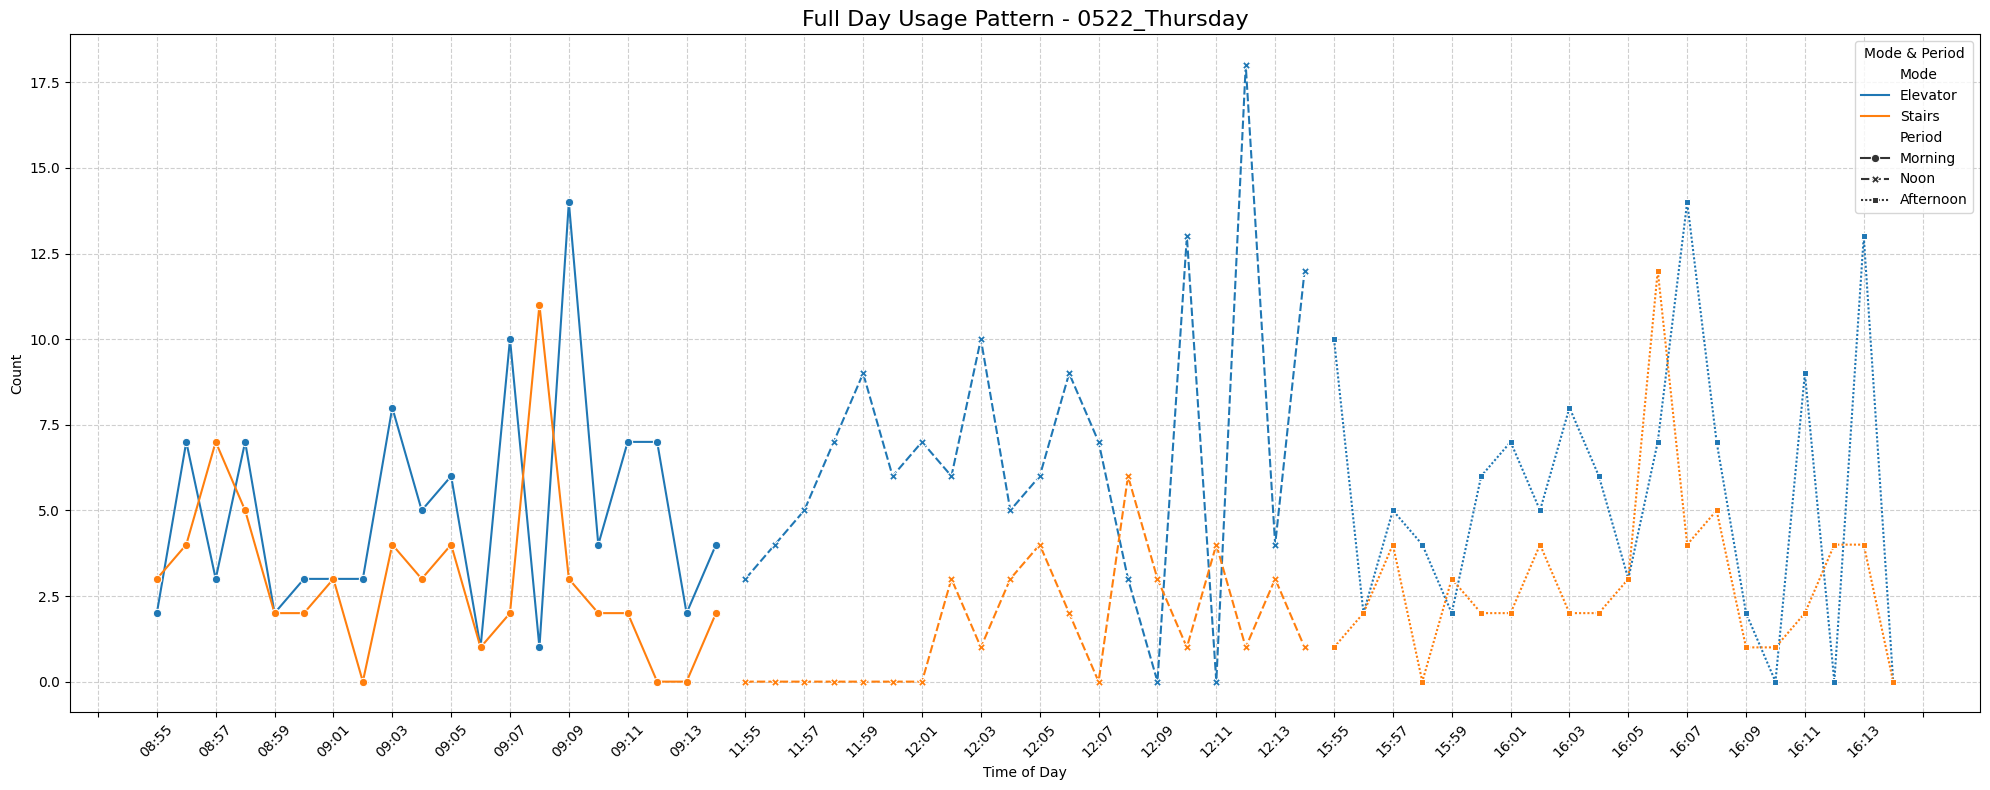

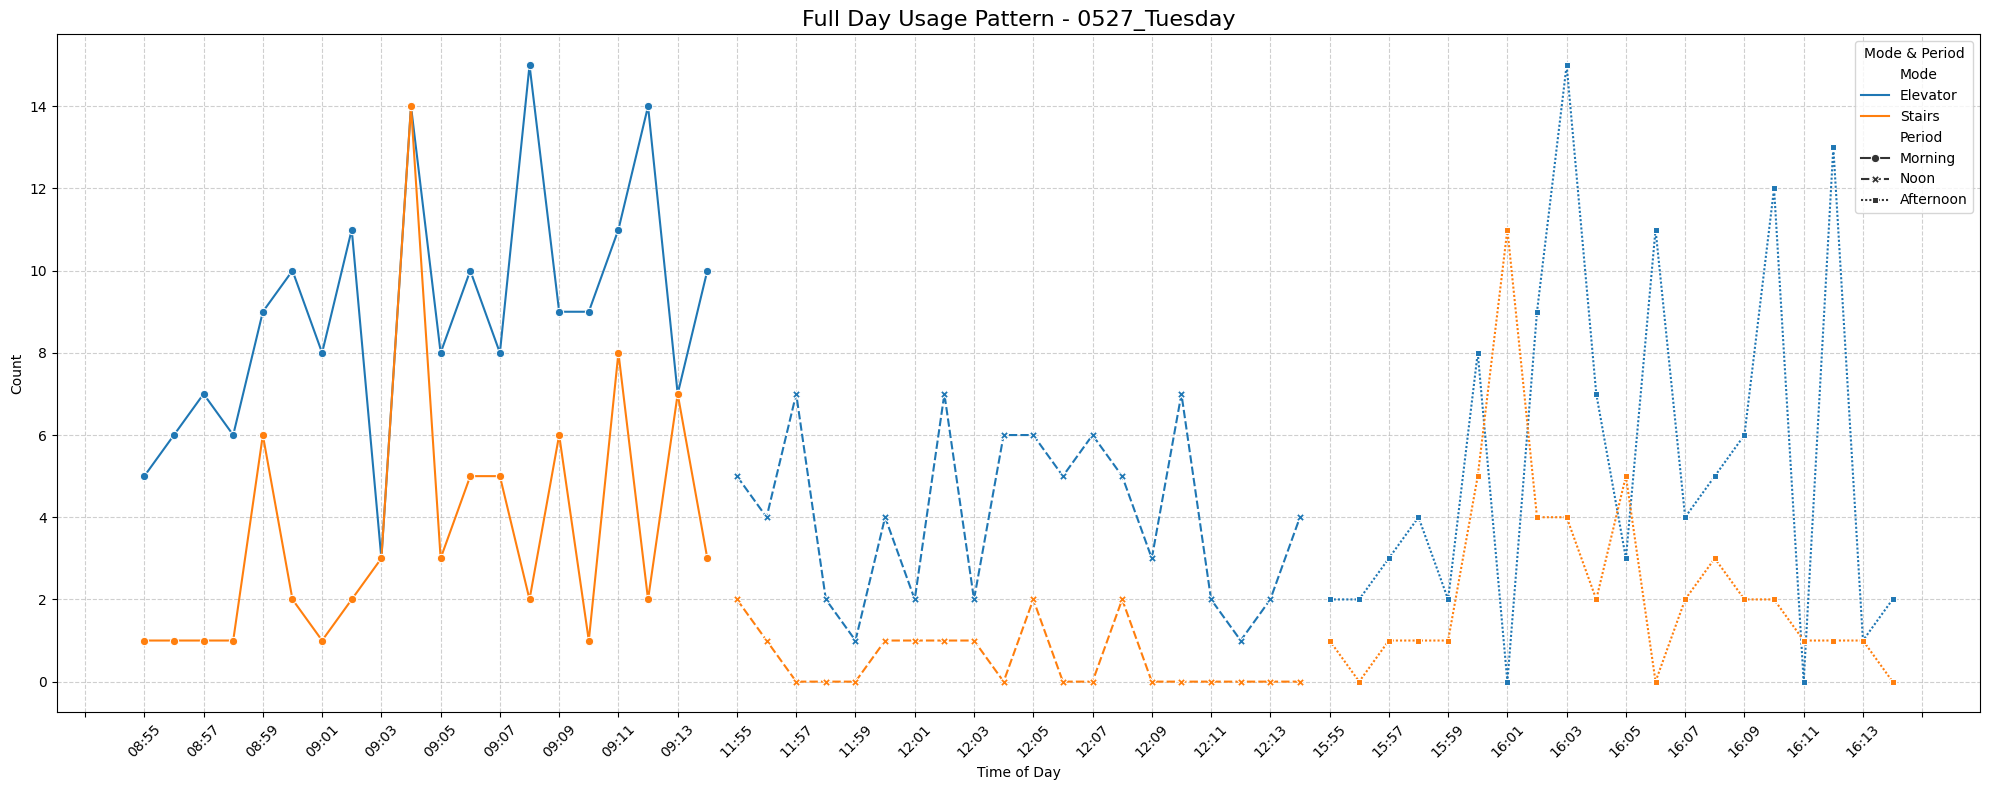

Script finished.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
from datetime import datetime, timedelta
import matplotlib.ticker as mticker

# --- 資料來源設定 ---
sheet_id = '1DWj6qFX6o_Swm2jo2ID1to0gAuQ48EhNSM6URPlgiqc'
sheet_names = ['Avg', '0522_Thursday', '0527_Tuesday']

periods_eng = ['Morning', 'Noon', 'Afternoon']
period_start_times = {
    'Morning': '08:55',
    'Noon': '11:55',
    'Afternoon': '15:55'
}

# 根據起始時間產生時間標籤 (HH:MM 格式)
def generate_times(start_str, count):
    base = datetime.strptime(start_str, '%H:%M')
    return [(base + timedelta(minutes=i)).strftime('%H:%M') for i in range(count)]

# 資料擷取與轉換函式
def fetch_and_transform(sheet_name):
    """
    從指定的 Google Sheet 工作表讀取資料，並轉換為適合繪圖的長格式(long format)。
    針對 'avg' 和其他工作表使用不同的讀取策略。
    """
    try:
        encoded_sheet_name = urllib.parse.quote(sheet_name)
        url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={encoded_sheet_name}'

        # 針對 'avg' 工作表使用 header=2 讀取，因為其格式較特殊
        if sheet_name == 'avg':
            df = pd.read_csv(url, header=2)
            col_groups = [(0, 1), (2, 3), (4, 5)]
            data_df = df
        else:
            # 其他工作表 ('0527', '0522-1') 假設使用標準格式
            df = pd.read_csv(url, header=0)
            col_groups = [(1, 2), (3, 4), (5, 6)]
            # 假設資料從第二行開始
            data_df = df.iloc[1:].reset_index(drop=True)

    except Exception as e:
        print(f"Error reading sheet '{sheet_name}': {e}")
        return pd.DataFrame()

    dfs = []
    for (col_e, col_s), period_eng in zip(col_groups, periods_eng):
        # 選擇對應時段的搭電梯和走樓梯欄位
        temp = data_df.iloc[:, [col_e, col_s]].copy()
        temp.columns = ['Elevator', 'Stairs']
        temp = temp.dropna(how='all').reset_index(drop=True)

        if temp.empty:
            continue

        # 動態產生時間標籤
        time_labels = generate_times(period_start_times[period_eng], len(temp))
        temp['Time'] = time_labels
        temp['Period'] = period_eng

        # 使用 melt 將資料從寬格式轉為長格式
        temp = temp.melt(id_vars=['Time', 'Period'],
                         value_vars=['Elevator', 'Stairs'],
                         var_name='Mode', value_name='Count')

        temp['Sheet'] = sheet_name
        temp['Count'] = pd.to_numeric(temp['Count'], errors='coerce')
        temp = temp.dropna(subset=['Count'])
        dfs.append(temp)

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


# --- 主程式 ---
all_combined = pd.concat([fetch_and_transform(sheet) for sheet in sheet_names], ignore_index=True)

# 為每個工作表的資料繪製一張圖
for sheet in all_combined['Sheet'].unique():
    sheet_data = all_combined[all_combined['Sheet'] == sheet]

    if sheet_data.empty:
        print(f"No data to plot for sheet: {sheet}")
        continue

    # 建立一個圖表
    plt.figure(figsize=(20, 8))

    # 在單一圖表上繪製所有資料
    # hue='Mode' -> 用顏色區分 Elevator/Stairs
    # style='Period' -> 用線型區分 Morning/Noon/Afternoon
    ax = sns.lineplot(data=sheet_data, x='Time', y='Count', hue='Mode',
                     style='Period', markers=True, dashes=True)

    # 設定圖表標題和標籤
    ax.set_title(f'Full Day Usage Pattern - {sheet}', fontsize=16)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Count')

    # 優化 X 軸標籤，避免過於擁擠
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(40)) # 最多顯示 40 個標籤

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Mode & Period')

    # 自動調整排版
    plt.tight_layout()
    plt.show()

print("Script finished.")


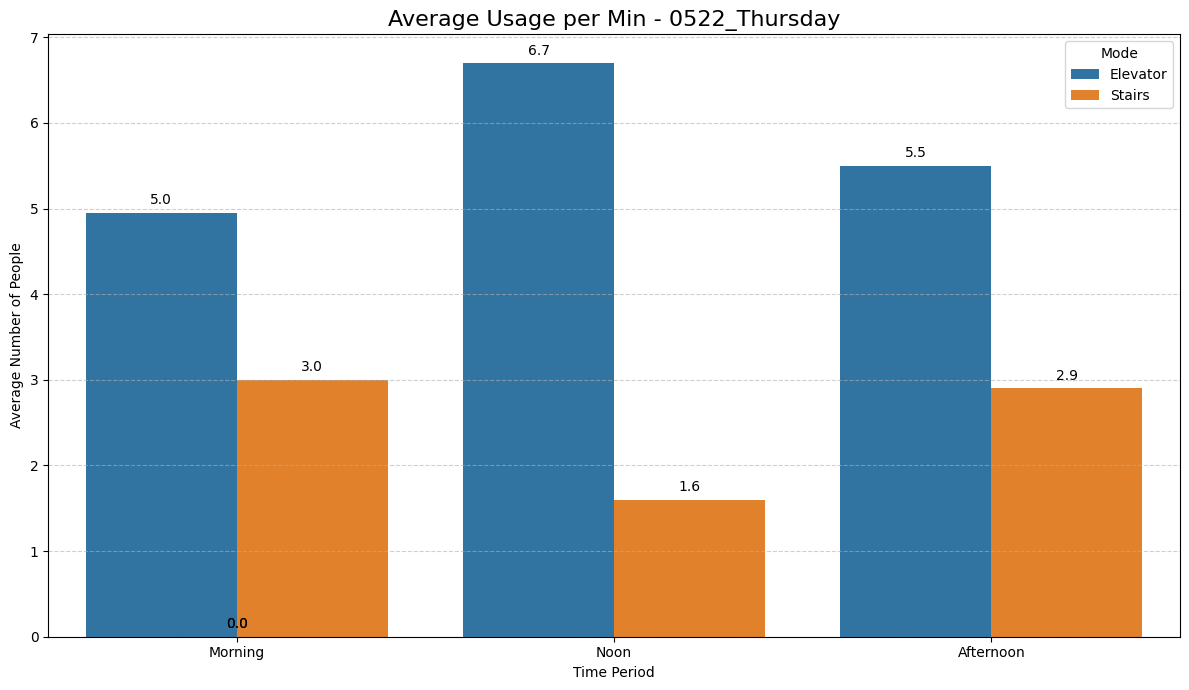

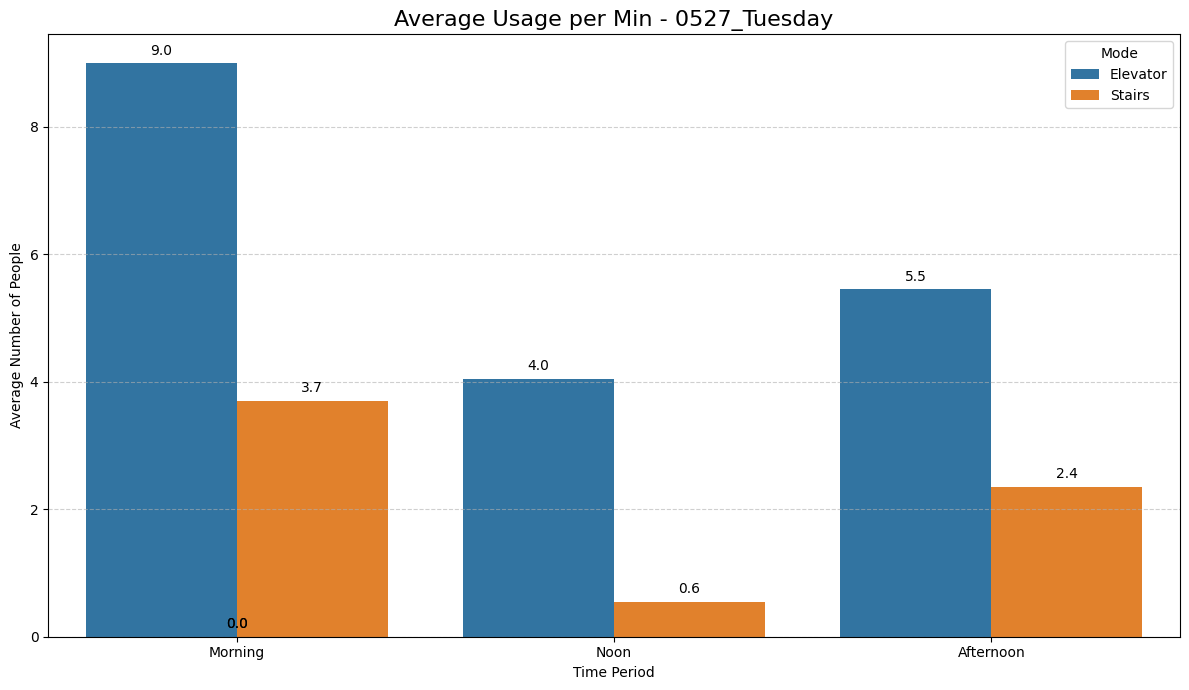

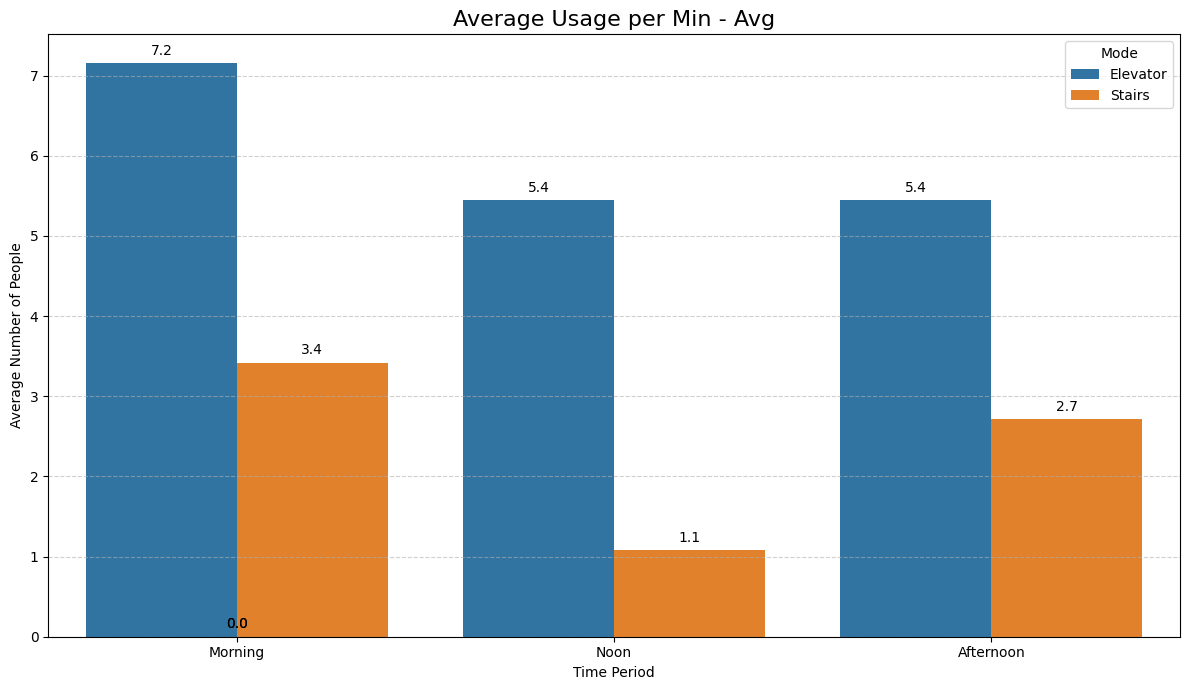

Script finished.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
from datetime import datetime, timedelta
import matplotlib.ticker as mticker

# --- 資料來源設定 ---
sheet_id = '1DWj6qFX6o_Swm2jo2ID1to0gAuQ48EhNSM6URPlgiqc'
sheet_names = ['Avg', '0522_Thursday', '0527_Tuesday']

periods_eng = ['Morning', 'Noon', 'Afternoon']
period_start_times = {
    'Morning': '08:55',
    'Noon': '11:55',
    'Afternoon': '15:55'
}

# 根據起始時間產生時間標籤 (HH:MM 格式)
def generate_times(start_str, count):
    base = datetime.strptime(start_str, '%H:%M')
    return [(base + timedelta(minutes=i)).strftime('%H:%M') for i in range(count)]

# 資料擷取與轉換函式
def fetch_and_transform(sheet_name):
    """
    從指定的 Google Sheet 工作表讀取資料，並轉換為適合繪圖的長格式(long format)。
    針對 'avg' 和其他工作表使用不同的讀取策略。
    """
    try:
        encoded_sheet_name = urllib.parse.quote(sheet_name)
        url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={encoded_sheet_name}'

        # 針對 'avg' 工作表使用 header=2 讀取，因為其格式較特殊
        if sheet_name == 'avg':
            df = pd.read_csv(url, header=2)
            col_groups = [(0, 1), (2, 3), (4, 5)]
            data_df = df
        else:
            # 其他工作表 ('0527', '0522-1') 假設使用標準格式
            df = pd.read_csv(url, header=0)
            col_groups = [(1, 2), (3, 4), (5, 6)]
            # 假設資料從第二行開始
            data_df = df.iloc[1:].reset_index(drop=True)

    except Exception as e:
        print(f"Error reading sheet '{sheet_name}': {e}")
        return pd.DataFrame()

    dfs = []
    for (col_e, col_s), period_eng in zip(col_groups, periods_eng):
        # 選擇對應時段的搭電梯和走樓梯欄位
        temp = data_df.iloc[:, [col_e, col_s]].copy()
        temp.columns = ['Elevator', 'Stairs']
        temp = temp.dropna(how='all').reset_index(drop=True)

        if temp.empty:
            continue

        # 動態產生時間標籤
        time_labels = generate_times(period_start_times[period_eng], len(temp))
        temp['Time'] = time_labels
        temp['Period'] = period_eng

        # 使用 melt 將資料從寬格式轉為長格式
        temp = temp.melt(id_vars=['Time', 'Period'],
                         value_vars=['Elevator', 'Stairs'],
                         var_name='Mode', value_name='Count')

        temp['Sheet'] = sheet_name
        temp['Count'] = pd.to_numeric(temp['Count'], errors='coerce')
        temp = temp.dropna(subset=['Count'])
        dfs.append(temp)

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


# --- 主程式 ---
all_combined = pd.concat([fetch_and_transform(sheet) for sheet in sheet_names], ignore_index=True)

# --- 計算各時段平均值 ---
# 根據 Sheet, Period, 和 Mode 分組，並計算 Count 的平均值
avg_data = all_combined.groupby(['Sheet', 'Period', 'Mode'], as_index=False)['Count'].mean()

# --- 繪製長條圖 ---
# 為每個工作表的資料繪製一張圖
for sheet in avg_data['Sheet'].unique():
    sheet_avg_data = avg_data[avg_data['Sheet'] == sheet]

    if sheet_avg_data.empty:
        print(f"No data to plot for sheet: {sheet}")
        continue

    # 建立圖表
    plt.figure(figsize=(12, 7))

    # 使用 barplot 繪製分組長條圖
    # x='Period' -> X軸為時段
    # y='Count' -> Y軸為計算出的平均人數
    # hue='Mode' -> 用顏色區分 Elevator/Stairs
    ax = sns.barplot(data=sheet_avg_data, x='Period', y='Count', hue='Mode',
                     order=['Morning', 'Noon', 'Afternoon']) # 確保X軸順序正確

    # 設定圖表標題和標籤
    ax.set_title(f'Average Usage per Min - {sheet}', fontsize=16)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Average Number of People')

    # 在每個長條上方顯示數值
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=10)

    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.legend(title='Mode')

    # 自動調整排版
    plt.tight_layout()
    plt.show()

print("Script finished.")


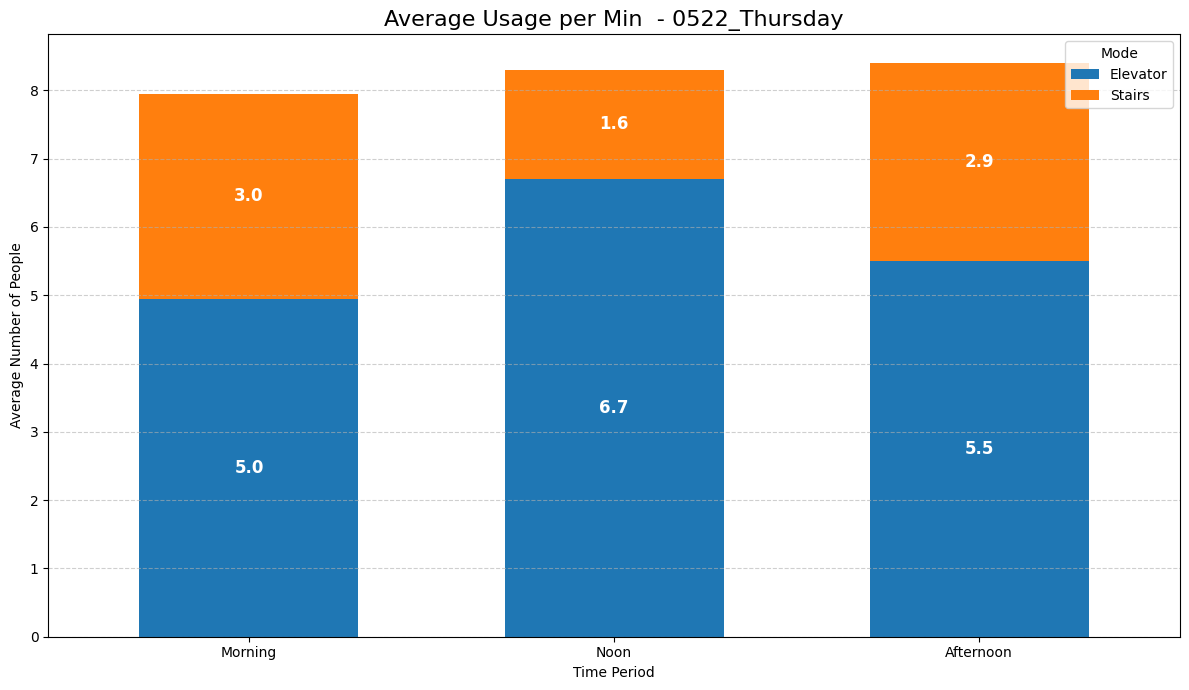

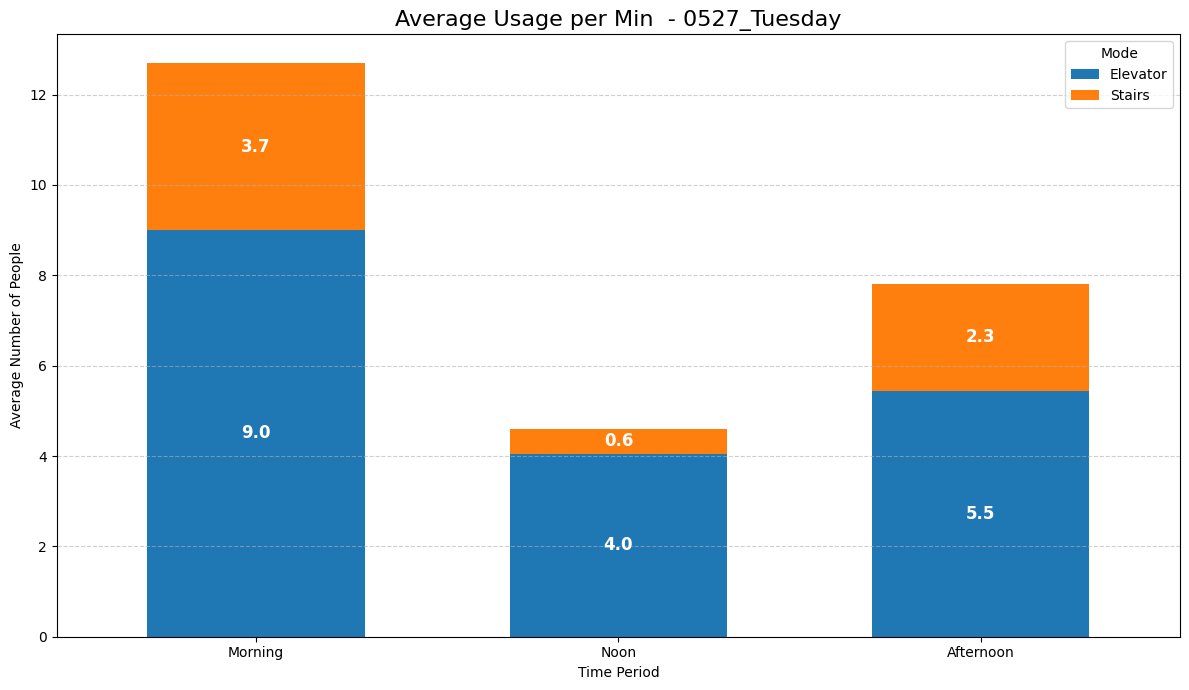

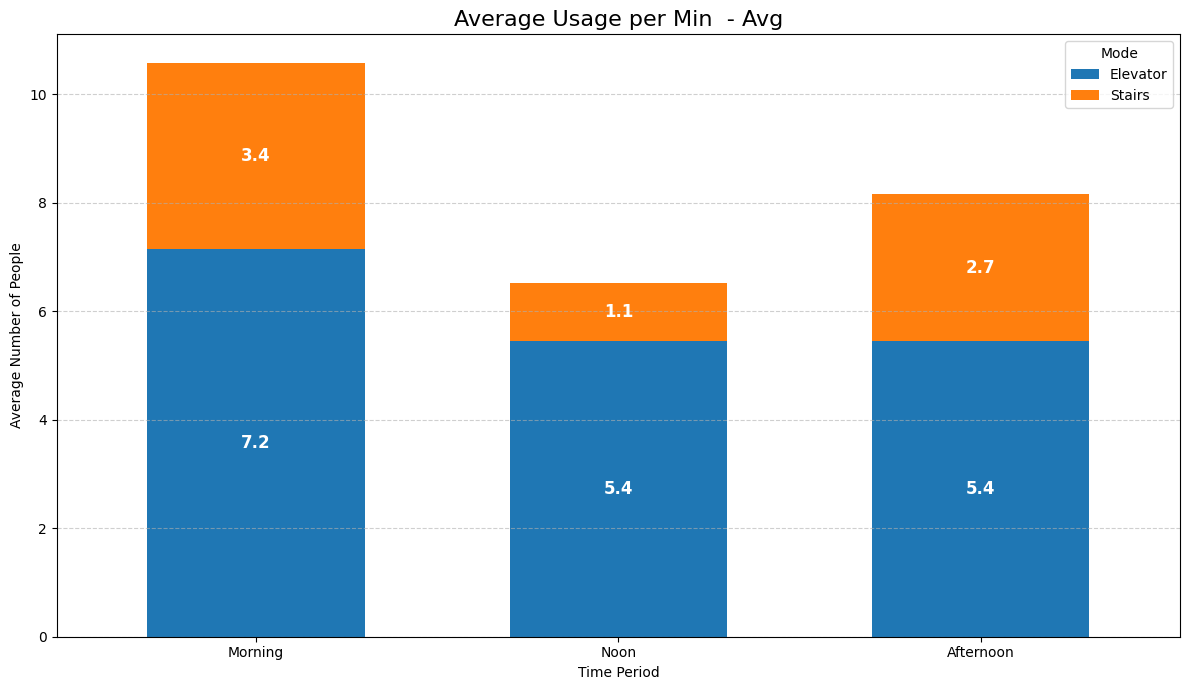

Script finished.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
from datetime import datetime, timedelta
import matplotlib.ticker as mticker

# --- 資料來源設定 ---
sheet_id = '1DWj6qFX6o_Swm2jo2ID1to0gAuQ48EhNSM6URPlgiqc'
sheet_names = ['Avg', '0522_Thursday', '0527_Tuesday']

periods_eng = ['Morning', 'Noon', 'Afternoon']
period_start_times = {
    'Morning': '08:55',
    'Noon': '11:55',
    'Afternoon': '15:55'
}

# 根據起始時間產生時間標籤 (HH:MM 格式)
def generate_times(start_str, count):
    base = datetime.strptime(start_str, '%H:%M')
    return [(base + timedelta(minutes=i)).strftime('%H:%M') for i in range(count)]

# 資料擷取與轉換函式
def fetch_and_transform(sheet_name):
    """
    從指定的 Google Sheet 工作表讀取資料，並轉換為適合繪圖的長格式(long format)。
    針對 'avg' 和其他工作表使用不同的讀取策略。
    """
    try:
        encoded_sheet_name = urllib.parse.quote(sheet_name)
        url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={encoded_sheet_name}'

        # 針對 'avg' 工作表使用 header=2 讀取，因為其格式較特殊
        if sheet_name == 'avg':
            df = pd.read_csv(url, header=2)
            col_groups = [(0, 1), (2, 3), (4, 5)]
            data_df = df
        else:
            # 其他工作表 ('0527', '0522-1') 假設使用標準格式
            df = pd.read_csv(url, header=0)
            col_groups = [(1, 2), (3, 4), (5, 6)]
            # 假設資料從第二行開始
            data_df = df.iloc[1:].reset_index(drop=True)

    except Exception as e:
        print(f"Error reading sheet '{sheet_name}': {e}")
        return pd.DataFrame()

    dfs = []
    for (col_e, col_s), period_eng in zip(col_groups, periods_eng):
        # 選擇對應時段的搭電梯和走樓梯欄位
        temp = data_df.iloc[:, [col_e, col_s]].copy()
        temp.columns = ['Elevator', 'Stairs']
        temp = temp.dropna(how='all').reset_index(drop=True)

        if temp.empty:
            continue

        # 動態產生時間標籤
        time_labels = generate_times(period_start_times[period_eng], len(temp))
        temp['Time'] = time_labels
        temp['Period'] = period_eng

        # 使用 melt 將資料從寬格式轉為長格式
        temp = temp.melt(id_vars=['Time', 'Period'],
                         value_vars=['Elevator', 'Stairs'],
                         var_name='Mode', value_name='Count')

        temp['Sheet'] = sheet_name
        temp['Count'] = pd.to_numeric(temp['Count'], errors='coerce')
        temp = temp.dropna(subset=['Count'])
        dfs.append(temp)

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


# --- 主程式 ---
all_combined = pd.concat([fetch_and_transform(sheet) for sheet in sheet_names], ignore_index=True)

# --- 計算各時段平均值 ---
# 根據 Sheet, Period, 和 Mode 分組，並計算 Count 的平均值
avg_data = all_combined.groupby(['Sheet', 'Period', 'Mode'], as_index=False)['Count'].mean()

# --- 繪製堆疊長條圖 ---
for sheet in avg_data['Sheet'].unique():
    sheet_avg_data = avg_data[avg_data['Sheet'] == sheet]

    if sheet_avg_data.empty:
        print(f"No data to plot for sheet: {sheet}")
        continue

    # 將資料從長格式轉換為寬格式，方便繪製堆疊圖
    pivot_df = sheet_avg_data.pivot_table(index='Period', columns='Mode', values='Count').reindex(['Morning', 'Noon', 'Afternoon'])

    # 確保欄位順序以固定顏色
    if 'Elevator' in pivot_df.columns and 'Stairs' in pivot_df.columns:
        pivot_df = pivot_df[['Elevator', 'Stairs']]

    # 建立圖表
    fig, ax = plt.subplots(figsize=(12, 7))

    # 使用 pandas 的 plot 功能繪製堆疊長條圖
    pivot_df.plot(kind='bar', stacked=True, ax=ax, width=0.6)

    # 設定圖表標題和標籤
    ax.set_title(f'Average Usage per Min  - {sheet}', fontsize=16)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Average Number of People')

    # 在每個堆疊區塊的中間顯示數值
    for c in ax.containers:
        # 只為高度大於 0 的區塊加上標籤
        labels = [f'{v.get_height():.1f}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=12, fontweight='bold')

    # 讓 X 軸標籤保持水平
    plt.xticks(rotation=0)

    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.legend(title='Mode')

    # 自動調整排版
    plt.tight_layout()
    plt.show()

print("Script finished.")



--- 正在產生指定需求的合併分析圖表 ---


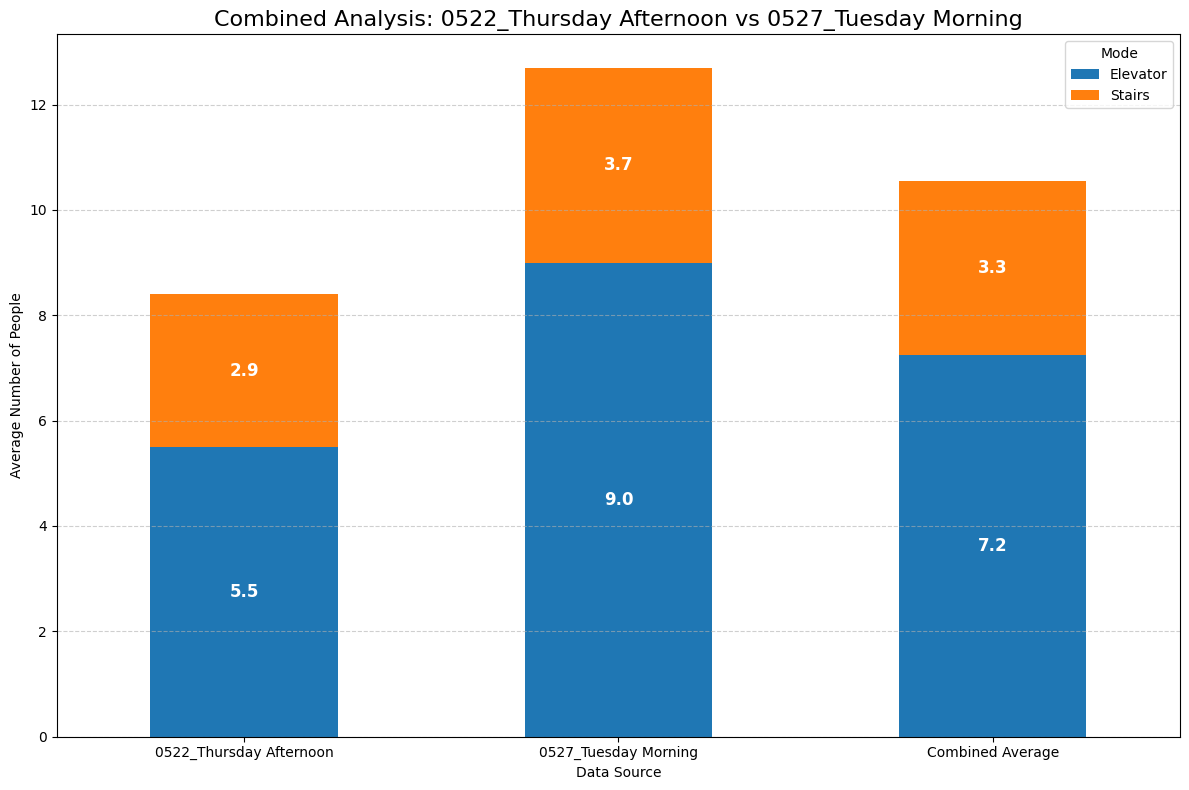

Script finished.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
from datetime import datetime, timedelta
import matplotlib.ticker as mticker

# --- 資料來源設定 ---
sheet_id = '1DWj6qFX6o_Swm2jo2ID1to0gAuQ48EhNSM6URPlgiqc'
sheet_names = ['Avg', '0522_Thursday', '0527_Tuesday']

periods_eng = ['Morning', 'Noon', 'Afternoon']
period_start_times = {
    'Morning': '08:55',
    'Noon': '11:55',
    'Afternoon': '15:55'
}

# 根據起始時間產生時間標籤 (HH:MM 格式)
def generate_times(start_str, count):
    base = datetime.strptime(start_str, '%H:%M')
    return [(base + timedelta(minutes=i)).strftime('%H:%M') for i in range(count)]

# 資料擷取與轉換函式
def fetch_and_transform(sheet_name):
    """
    從指定的 Google Sheet 工作表讀取資料，並轉換為適合繪圖的長格式(long format)。
    針對 'Avg' 和其他工作表使用不同的讀取策略。
    """
    try:
        encoded_sheet_name = urllib.parse.quote(sheet_name)
        url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={encoded_sheet_name}'

        # 針對 'Avg' 工作表使用 header=2 讀取，因為其格式較特殊
        if sheet_name == 'Avg':
            df = pd.read_csv(url, header=2)
            col_groups = [(0, 1), (2, 3), (4, 5)]
            data_df = df
        else:
            # 其他工作表 ('0522_Thursday', '0527_Tuesday') 假設使用標準格式
            df = pd.read_csv(url, header=0)
            col_groups = [(1, 2), (3, 4), (5, 6)]
            # 假設資料從第二行開始
            data_df = df.iloc[1:].reset_index(drop=True)

    except Exception as e:
        print(f"Error reading sheet '{sheet_name}': {e}")
        return pd.DataFrame()

    dfs = []
    for (col_e, col_s), period_eng in zip(col_groups, periods_eng):
        # 選擇對應時段的搭電梯和走樓梯欄位
        temp = data_df.iloc[:, [col_e, col_s]].copy()
        temp.columns = ['Elevator', 'Stairs']
        temp = temp.dropna(how='all').reset_index(drop=True)

        if temp.empty:
            continue

        # 動態產生時間標籤
        time_labels = generate_times(period_start_times[period_eng], len(temp))
        temp['Time'] = time_labels
        temp['Period'] = period_eng

        # 使用 melt 將資料從寬格式轉為長格式
        temp = temp.melt(id_vars=['Time', 'Period'],
                         value_vars=['Elevator', 'Stairs'],
                         var_name='Mode', value_name='Count')

        temp['Sheet'] = sheet_name
        temp['Count'] = pd.to_numeric(temp['Count'], errors='coerce')
        temp = temp.dropna(subset=['Count'])
        dfs.append(temp)

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


# --- 主程式 ---
all_combined = pd.concat([fetch_and_transform(sheet) for sheet in sheet_names], ignore_index=True)

# --- 全新邏輯：針對特定需求的合併分析 ---
print("\n--- 正在產生指定需求的合併分析圖表 ---")

# 1. 篩選出需要的特定資料
data_0522_afternoon = all_combined[(all_combined['Sheet'] == '0522_Thursday') & (all_combined['Period'] == 'Afternoon')]
data_0527_morning = all_combined[(all_combined['Sheet'] == '0527_Tuesday') & (all_combined['Period'] == 'Morning')]

# 2. 分別計算這兩組資料的平均人數
avg_0522_afternoon = data_0522_afternoon.groupby('Mode')['Count'].mean()
avg_0527_morning = data_0527_morning.groupby('Mode')['Count'].mean()

# 檢查資料是否存在，若任一組不存在則終止
if avg_0522_afternoon.empty or avg_0527_morning.empty:
    print("Error: Could not find data for '0522_Thursday Afternoon' or '0527_Tuesday Morning'. Cannot perform combined analysis.")
else:
    # 3. 計算這兩組數據的「綜合平均」
    # 使用 .get(key, 0) 避免其中一項 (如 'Stairs') 沒數據時出錯
    avg_combined_elevator = (avg_0522_afternoon.get('Elevator', 0) + avg_0527_morning.get('Elevator', 0)) / 2
    avg_combined_stairs = (avg_0522_afternoon.get('Stairs', 0) + avg_0527_morning.get('Stairs', 0)) / 2

    # 4. 建立一個新的 DataFrame 來存放這三組要繪圖的數據
    final_data_dict = {
        'Category': [
            '0522_Thursday Afternoon', '0522_Thursday Afternoon',
            '0527_Tuesday Morning', '0527_Tuesday Morning',
            'Combined Average', 'Combined Average'
        ],
        'Mode': [
            'Elevator', 'Stairs',
            'Elevator', 'Stairs',
            'Elevator', 'Stairs'
        ],
        'Count': [
            avg_0522_afternoon.get('Elevator', 0), avg_0522_afternoon.get('Stairs', 0),
            avg_0527_morning.get('Elevator', 0), avg_0527_morning.get('Stairs', 0),
            avg_combined_elevator, avg_combined_stairs
        ]
    }
    final_plot_df = pd.DataFrame(final_data_dict)

    # 5. 將資料塑形並繪製堆疊長條圖
    pivot_final = final_plot_df.pivot_table(index='Category', columns='Mode', values='Count')
    # 重新排序X軸的項目
    pivot_final = pivot_final.reindex(['0522_Thursday Afternoon', '0527_Tuesday Morning', 'Combined Average'])
    if 'Elevator' in pivot_final.columns and 'Stairs' in pivot_final.columns:
        pivot_final = pivot_final[['Elevator', 'Stairs']] # 固定堆疊順序

    # 繪圖
    fig, ax = plt.subplots(figsize=(12, 8))
    pivot_final.plot(kind='bar', stacked=True, ax=ax, width=0.5)

    # 設定圖表標題與標籤
    ax.set_title('Combined Analysis: 0522_Thursday Afternoon vs 0527_Tuesday Morning', fontsize=16)
    ax.set_xlabel('Data Source')
    ax.set_ylabel('Average Number of People')

    # 在每個色塊中間加上數值標籤
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=12, fontweight='bold')

    plt.xticks(rotation=0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.legend(title='Mode')
    plt.tight_layout()
    plt.show()

print("Script finished.")
